In [1]:
import os
import pandas as pd
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
pwd

'/home/nbuser/library/Taller01'

## IDEAM

In [4]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Medellin'
fuente = 'IDEAM'
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_pd = pd.read_csv(serie_csv, sep = ';', encoding='latin-1')

In [5]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) & (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno) & (serie_horaria["MES"] == mes)), nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1], "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno) & (serie_ghi_mensual["MES"] == mes)), "DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno) & (serie_ghi_mensual["MES"] == mes)), "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

In [6]:
ghi_mensual_loc = ghi_mensual(serie_pd)
ghi_diario_loc = ghi_dia(ghi_mensual_loc)
datos_IDEAM = sorted(ghi_diario_loc["GHIdiario"])

# Calculo de ENFICC

In [7]:
percentil = 0.01
enficc = ghi_diario_loc.quantile(q=percentil, numeric_only=True)["GHIdiario"]
print('La ENFICC 99% es: ', enficc)

La ENFICC 99% es:  3.53519358791


## NREL

Esta serie no tiene la mimsma dimensión ni el mismo inicio que la serie IDEAM, por esto se aplica un ajuste que inicializa los datos desde el año 2006, este es el año en la que inician los datos de la serie IDEAM.

In [8]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Medellin'
fuente = 'NREL'
serie_csv_nrel = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_pd_nrel2 = pd.read_csv(serie_csv_nrel, sep = ';', encoding='latin-1')
#Se da la dimension de la serie NREL igual a la de IDEAM, la serie NREL inicia en el año 2005 mientras IDEAM en 2006. Ahora ambas inician en 2006 y así sera para todos los calculos
serie_pd_nrel=serie_pd_nrel2[serie_pd_nrel2['AÑO'] >= 2006]
wer=range(0,len(serie_pd_nrel))
serie_pd_nrel.index=wer

In [9]:
#Se comprueba la misma dimension de los datos
len(serie_pd_nrel)==len(serie_pd)

True

In [10]:
ghi_mensual_loc2 = ghi_mensual(serie_pd_nrel)
ghi_diario_loc2 = ghi_dia(ghi_mensual_loc2)
datos_NREL = sorted(ghi_diario_loc2["GHIdiario"])

# Gráfica comparativa IDEAM y NREL

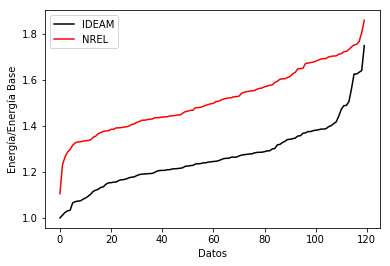

In [11]:
pylab.xlabel("Datos")
pylab.ylabel("Energía/Energía Base")
numdatos = range(len(datos_IDEAM))
numdatosnrel=range(len(datos_NREL))
pylab.plot(numdatos,datos_IDEAM/datos_IDEAM[0],'-k', label='IDEAM')
pylab.plot(numdatosnrel,datos_NREL/datos_IDEAM[0],'-r', label='NREL')
pylab.legend(loc='upper left')
pylab.savefig(os.path.join(output_dir,'medellin_IDEAM.png'), dpi=600)

A partir de esta gráfica se puede observar que al comparar las dos series en los 10 años la serie satelital sobre estima la radiación que ha sido medida. En este caso un 24%. Las series se encuentran normalizadas con respecto al valor mínimo de las series de IDEAM

# Metodología Medición-Correlación-Predicción (MCP)

A continuación se realizan las funciones que toman una lista de datos de 10 años y selecciona un año y unos meses específicos, posteriormente dicha serie de datos se les realiza el ajuste MCP, tal como se muestra en el protocolo.

In [12]:
#Función para seleccionar un período de datos de la lista de IDEAM. 
#Sus parametros son el mes y el rango de meses que se quieren evaluar
def periodo (serie_larga, agno, mes_inicio, mes_final):
    a=[]
    for mes in range(mes_inicio,mes_final):
            datos=serie_larga.loc[(serie_larga["AÑO"] == agno)& (serie_larga["MES"] == mes)]
            a.append(datos)
#Se utiliza ignore_index para evitar errores de repeticion de numero de indice cuando se concatenan los datos
            ghi_df = pd.concat(a, ignore_index=True)
    return ghi_df

In [13]:
#Ejemplo y prueba de la función período
periodo(serie_pd, 2006, 1, 13)

,AÑO,MES,DIA,HORA,IDEAM
0,2006,1,1,0,0.000000
1,2006,1,1,1,0.000000
2,2006,1,1,2,0.000000
3,2006,1,1,3,0.000000
4,2006,1,1,4,0.000000
5,2006,1,1,5,0.000000
6,2006,1,1,6,1.005429
7,2006,1,1,7,14.076010
8,2006,1,1,8,81.439775
9,2006,1,1,9,234.265031


In [14]:
#Ejemplo y prueba de la función período para serie NREL
periodo(serie_pd_nrel, 2006, 1, 13)

,AÑO,MES,DIA,HORA,NREL
0,2006,1,1,0,0.0
1,2006,1,1,1,0.0
2,2006,1,1,2,0.0
3,2006,1,1,3,0.0
4,2006,1,1,4,0.0
5,2006,1,1,5,0.0
6,2006,1,1,6,6.5
7,2006,1,1,7,91.5
8,2006,1,1,8,239.0
9,2006,1,1,9,652.0


In [15]:
#Ajuste MCP
op_ideam=periodo(serie_pd, 2015, 1, 13)
op_nrel=periodo(serie_pd_nrel, 2015, 1, 13)
op_ideam2=periodo(serie_pd, 2010, 1, 13)
op_nrel2=periodo(serie_pd_nrel, 2010, 1, 13)

def ajuste (ideam, nrel):
    mean_y=ideam['IDEAM'].mean()
    mean_x=nrel['NREL'].mean()
    std_y=ideam['IDEAM'].std()
    std_x=nrel['NREL'].std()
    a=(mean_y-((std_y/std_x)*mean_x)+((std_y/std_x)*serie_pd_nrel['NREL']))
#Los datos ajustados negativos se convierten en cero
    a[a < 0] = 0
#Se crea un nuevo DataFrame para los datos ajustados
    lineas={'AÑO':serie_pd_nrel['AÑO'],'MES':serie_pd_nrel['MES'],'DIA':serie_pd_nrel['DIA'],'HORA':serie_pd_nrel['HORA'],'NREL':a}
    lineas_data=pd.DataFrame(lineas)
    return lineas_data

In [16]:
#Datos de radiacion ajustados
radiacion_ajustada=ajuste(op_ideam, op_nrel)
radiacion_ajustada2=ajuste(op_ideam2, op_nrel2)

In [17]:
#Promedios mensuales y totales, tal como la primera parte del ejercicio pero para datos ajustados
ghi_mensual_ajuste = ghi_mensual(radiacion_ajustada)
ghi_diario_ajuste = ghi_dia(ghi_mensual_ajuste)
datos_AJUSTE = sorted(ghi_diario_ajuste["GHIdiario"])
ghi_mensual_ajuste2 = ghi_mensual(radiacion_ajustada2)
ghi_diario_ajuste2 = ghi_dia(ghi_mensual_ajuste2)
datos_AJUSTE2 = sorted(ghi_diario_ajuste2["GHIdiario"])

Así como se realizo con los datos de las series IDEAM y NREL se realiza el calculo del promedio mensual y diario de la serie ajustada para la realización de las gráficas.

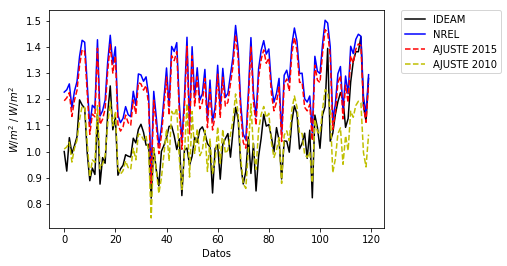

In [18]:
pylab.xlabel("Datos")
pylab.ylabel("$W/{m^{2}}$ / $W/{m^{2}}$")
mensual_ideam=range(len(ghi_mensual_loc))
mensual_nrel=range(len(ghi_mensual_loc2))
numdatosnrel_ajuste=range(len(ghi_diario_ajuste ))
pylab.plot(mensual_ideam,ghi_mensual_loc['GHImes']/ghi_mensual_loc['GHImes'][0],'-k', label='IDEAM')
pylab.plot(mensual_nrel,ghi_mensual_loc2['GHImes']/ghi_mensual_loc['GHImes'][0],'-b', label='NREL')
pylab.plot(numdatosnrel_ajuste,ghi_mensual_ajuste['GHImes']/ghi_mensual_loc['GHImes'][0],'--r', label='AJUSTE 2015')
pylab.plot(numdatosnrel_ajuste,ghi_mensual_ajuste2['GHImes']/ghi_mensual_loc['GHImes'][0],'--y', label='AJUSTE 2010')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.savefig(os.path.join(output_dir,'medellin_corregido.png'), dpi=600)

En la presente gráfica se muestran las series NREL, IDEAM y los ajustes de los años 2010 y 2015. En este caso se observa que el ajuste para el año 2015 se encuentra alejado de lo deseado, la serie IDEAM, mientras que en el caso del ajuste del año 2010 la serie encuentra similitud con la serie IDEAM. En este caso, se analiza que en caso de tomar decisiones la serie de ajuste para el año 2010 es más significativa que la del año 2015. Este análisis se profundizará con el cálculo de errores presentado posteriormente. 

Analizando el año 2010 historicamente se observa que dicho año correspondio al fenómeno climatologico de la niña, afectando así los datos de la radiación, en este caso la medida satelitalmente.

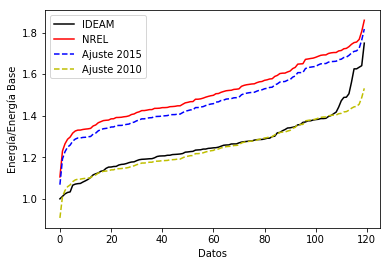

In [19]:
pylab.xlabel("Datos")
pylab.ylabel("Energía/Energía Base")
numdatos = range(len(datos_IDEAM))
numdatosnrel=range(len(datos_NREL))
pylab.plot(numdatos,datos_IDEAM/datos_IDEAM[0],'-k', label='IDEAM')
pylab.plot(numdatosnrel,datos_NREL/datos_IDEAM[0],'-r', label='NREL')
pylab.plot(numdatos,datos_AJUSTE/datos_IDEAM[0], '--b', label='Ajuste 2015')
pylab.plot(numdatos,datos_AJUSTE2/datos_IDEAM[0], '--y', label='Ajuste 2010')
pylab.legend(loc='upper left')
pylab.savefig(os.path.join(output_dir,'medellin_correcion_hist.png'), dpi=600)

En la presente gráfica se comprueba el análisis anterior de la similitud de los datos ajustados del año 2010 con la serie IDEAM, y por otra parte, la similitud del ajuste del año 2015 con la serie NREL. Lo cual presenta que el ajuste con el año 2010 es más preciso a la hora de tomar decisiones. Nuevamente, se analizara posteriormente con el cálculo de los errores.

# Calculo de errores

## RMSEn

In [20]:
# Para el calculo de este tipo de error se utiliza la ecuacion del protocolo
#Creación de un nuevo data frame para guardar los datos de IDEAM y NREL, esto para que tengan el mismo nombre y Python pueda hacer operaciones
#Se definen variables
x_obs=serie_pd['IDEAM']
x_mod=serie_pd_nrel['NREL']
n=len(x_obs)

In [21]:
# Se comprueba que el tamaño n de los datos sea el mismo para el calculo
len(x_mod)==len(x_obs)

True

In [22]:
#Calculo
def RMSEn(xmo):
    x=(sqrt((1/n)*(((x_obs-xmo)**2).sum())))/(x_obs.max()-x_obs.min())*100
#Se redondea a 3 numeros decimales
    y=round(x,3)
    return y
print('El error RMSEn es:', RMSEn(x_mod),'%')

El error RMSEn es: 11.711 %


## MBE

In [23]:
# Se utilizan las mismas listas creadas para el RMSEn
# Calculo
def MBE(xmo):
    x=((xmo-x_obs).sum())/x_obs.sum()*100
#Se redondea a 3 numeros decimales
    y=round(x,3)
    return y
print('El error MBE es: ', MBE(x_mod),'%')

El error MBE es:  19.721 %


## KSI

In [24]:
#La entrada deben ser series en resolucion mensual, de lo contrario se pueden dar p-values muy bajos
def KSI (serie_ideam,serie_corregida):    
    ksi=stats.ks_2samp(serie_ideam,serie_corregida)
    y=ksi[1]
#Se redondea a 4 numeros decimales, esto puede producir p-values de 0
    pvalue=round(y,4)
    return pvalue
print('El p-value del calculo KSI es:', KSI(ghi_mensual(serie_pd)['GHImes'],ghi_mensual(radiacion_ajustada)['GHImes']))

El p-value del calculo KSI es: 0.0


En resumen, los errores para los datos tomados satelitalmente respecto a la serie IDEAM son:

In [25]:
#DataFrame para los errores de la serie NREL respecto a IDEAM
errores_nrel={'RMSEn %':[RMSEn(x_mod)],'MBE %':[MBE(x_mod)],'KSI p-value': [KSI(ghi_mensual(serie_pd)['GHImes'],ghi_mensual(radiacion_ajustada)['GHImes'])]}
errores_n=pd.DataFrame(errores_nrel, index=['Error'])
errores_n

,KSI p-value,MBE %,RMSEn %
Error,0.0,19.721,11.711


De lo anterior se puede decir que de acuerdo al calculo del p-value del KSI las series no se ajustan cuando se compara la medicion satelital NREL con los datos del IDEAM. Con los errores de MBE y RMSEn se observa que esta mayor a un rango del 5% por tal razón no resulta recomndable tener esta serie como medida de comparación para cálculos de la ENFICC.

# Comparacion con datos ajustados

En la siguiente linea de código se realizaran diferentes ajustes para 3, 6, 9 y 12 meses. Primero se toma la serie de datos para dichas series de tiempo, luego se aplica la función de ajuste para esas series, en el caso de errores MBE y RMSEn basta con el ajuste para su calculo. En el caso de error KSI es necesario hacer el promedio mensual de datos (tal como se describe en la función creada para dicho calculo). Todos estos calculos se guardan en diferentes variables para crear con más facilidad un DataFrame con la información dada, dicho DataFrame se muestra en la siguiente línea de código.

In [26]:
# Se definen diferentes periodos de tiempo para evaluar
#Para 3 meses, 6 meses, 9 meses y un año entero

#3 Meses
a006ideam=periodo(serie_pd, 2006, 1, 4)
a006nrel=periodo(serie_pd_nrel,2006,1,4)
a007ideam=periodo(serie_pd, 2007, 1, 4)
a007nrel=periodo(serie_pd_nrel,2007,1,4)
a008ideam=periodo(serie_pd, 2008,1, 4)
a008nrel=periodo(serie_pd_nrel,2008,1,4)
a009ideam=periodo(serie_pd, 2009, 1, 4)
a009nrel=periodo(serie_pd_nrel,2009,1,4)
a010ideam=periodo(serie_pd, 2010, 1, 4)
a010nrel=periodo(serie_pd_nrel,2010,1,4)
a011ideam=periodo(serie_pd, 2011, 1, 4)
a011nrel=periodo(serie_pd_nrel,2011,1,4)
a012ideam=periodo(serie_pd, 2012, 1, 4)
a012nrel=periodo(serie_pd_nrel,2012,1,4)
a013ideam=periodo(serie_pd, 2013, 1, 4)
a013nrel=periodo(serie_pd_nrel,2013,1,4)
a014ideam=periodo(serie_pd, 2014, 1, 4)
a014nrel=periodo(serie_pd_nrel,2014,1,4)
a015ideam=periodo(serie_pd, 2015, 1, 4)
a015nrel=periodo(serie_pd_nrel,2015,1,4)

#6 Meses
b006ideam=periodo(serie_pd, 2006, 1, 7)
b006nrel=periodo(serie_pd_nrel,2006,1,7)
b007ideam=periodo(serie_pd, 2007, 1, 7)
b007nrel=periodo(serie_pd_nrel,2007,1,7)
b008ideam=periodo(serie_pd, 2008,1, 7)
b008nrel=periodo(serie_pd_nrel,2008,1,7)
b009ideam=periodo(serie_pd, 2009, 1, 7)
b009nrel=periodo(serie_pd_nrel,2009,1,7)
b010ideam=periodo(serie_pd, 2010, 1, 7)
b010nrel=periodo(serie_pd_nrel,2010,1,7)
b011ideam=periodo(serie_pd, 2011, 1, 7)
b011nrel=periodo(serie_pd_nrel,2011,1,7)
b012ideam=periodo(serie_pd, 2012, 1, 7)
b012nrel=periodo(serie_pd_nrel,2012,1,7)
b013ideam=periodo(serie_pd, 2013, 1, 7)
b013nrel=periodo(serie_pd_nrel,2013,1,7)
b014ideam=periodo(serie_pd, 2014, 1, 7)
b014nrel=periodo(serie_pd_nrel,2014,1,7)
b015ideam=periodo(serie_pd, 2015, 1, 7)
b015nrel=periodo(serie_pd_nrel,2015,1,7)

#9 Meses
c006ideam=periodo(serie_pd, 2006, 1,10)
c006nrel=periodo(serie_pd_nrel,2006,1,10)
c007ideam=periodo(serie_pd, 2007, 1, 10)
c007nrel=periodo(serie_pd_nrel,2007,1,10)
c008ideam=periodo(serie_pd, 2008,1, 10)
c008nrel=periodo(serie_pd_nrel,2008,1,10)
c009ideam=periodo(serie_pd, 2009, 1,10)
c009nrel=periodo(serie_pd_nrel,2009,1,10)
c010ideam=periodo(serie_pd, 2010, 1,10)
c010nrel=periodo(serie_pd_nrel,2010,1,10)
c011ideam=periodo(serie_pd, 2011, 1,10)
c011nrel=periodo(serie_pd_nrel,2011,1,10)
c012ideam=periodo(serie_pd, 2012, 1,10)
c012nrel=periodo(serie_pd_nrel,2012,1,10)
c013ideam=periodo(serie_pd, 2013, 1,10)
c013nrel=periodo(serie_pd_nrel,2013,1,10)
c014ideam=periodo(serie_pd, 2014, 1,10)
c014nrel=periodo(serie_pd_nrel,2014,1,10)
c015ideam=periodo(serie_pd, 2015, 1,10)
c015nrel=periodo(serie_pd_nrel,2015,1,10)

#12 Meses/1 Año
d006ideam=periodo(serie_pd, 2006, 1,13)
d006nrel=periodo(serie_pd_nrel,2006,1,13)
d007ideam=periodo(serie_pd, 2007, 1, 13)
d007nrel=periodo(serie_pd_nrel,2007,1,13)
d008ideam=periodo(serie_pd, 2008,1, 13)
d008nrel=periodo(serie_pd_nrel,2008,1,13)
d009ideam=periodo(serie_pd, 2009, 1,13)
d009nrel=periodo(serie_pd_nrel,2009,1,13)
d010ideam=periodo(serie_pd, 2010, 1,13)
d010nrel=periodo(serie_pd_nrel,2010,1,13)
d011ideam=periodo(serie_pd, 2011, 1,13)
d011nrel=periodo(serie_pd_nrel,2011,1,13)
d012ideam=periodo(serie_pd, 2012, 1,13)
d012nrel=periodo(serie_pd_nrel,2012,1,13)
d013ideam=periodo(serie_pd, 2013, 1,13)
d013nrel=periodo(serie_pd_nrel,2013,1,13)
d014ideam=periodo(serie_pd, 2014, 1,13)
d014nrel=periodo(serie_pd_nrel,2014,1,13)
d015ideam=periodo(serie_pd, 2015, 1,13)
d015nrel=periodo(serie_pd_nrel,2015,1,13)

#Ajustes a todos
#3 Meses
a0=ajuste(a006ideam, a006nrel)['NREL']
a1=ajuste(a007ideam, a007nrel)['NREL']
a2=ajuste(a008ideam, a008nrel)['NREL']
a3=ajuste(a009ideam, a009nrel)['NREL']
a4=ajuste(a010ideam, a010nrel)['NREL']
a5=ajuste(a011ideam, a011nrel)['NREL']
a6=ajuste(a012ideam, a012nrel)['NREL']
a7=ajuste(a013ideam, a013nrel)['NREL']
a8=ajuste(a014ideam, a014nrel)['NREL']
a9=ajuste(a015ideam, a015nrel)['NREL']
#PARA KSI
ak0=ghi_mensual(ajuste(a006ideam, a006nrel))['GHImes']
ak1=ghi_mensual(ajuste(a007ideam, a007nrel))['GHImes']
ak2=ghi_mensual(ajuste(a008ideam, a008nrel))['GHImes']
ak3=ghi_mensual(ajuste(a009ideam, a009nrel))['GHImes']
ak4=ghi_mensual(ajuste(a010ideam, a010nrel))['GHImes']
ak5=ghi_mensual(ajuste(a011ideam, a011nrel))['GHImes']
ak6=ghi_mensual(ajuste(a012ideam, a012nrel))['GHImes']
ak7=ghi_mensual(ajuste(a013ideam, a013nrel))['GHImes']
ak8=ghi_mensual(ajuste(a014ideam, a014nrel))['GHImes']
ak9=ghi_mensual(ajuste(a015ideam, a015nrel))['GHImes']

#6 Meses
b0=ajuste(b006ideam, b006nrel)['NREL']
b1=ajuste(b007ideam, b007nrel)['NREL']
b2=ajuste(b008ideam, b008nrel)['NREL']
b3=ajuste(b009ideam, b009nrel)['NREL']
b4=ajuste(b010ideam, b010nrel)['NREL']
b5=ajuste(b011ideam, b011nrel)['NREL']
b6=ajuste(b012ideam, b012nrel)['NREL']
b7=ajuste(b013ideam, b013nrel)['NREL']
b8=ajuste(b014ideam, b014nrel)['NREL']
b9=ajuste(b015ideam, b015nrel)['NREL']
#PARA KSI
bk0=ghi_mensual(ajuste(b006ideam, b006nrel))['GHImes']
bk1=ghi_mensual(ajuste(b007ideam, b007nrel))['GHImes']
bk2=ghi_mensual(ajuste(b008ideam, b008nrel))['GHImes']
bk3=ghi_mensual(ajuste(b009ideam, b009nrel))['GHImes']
bk4=ghi_mensual(ajuste(b010ideam, b010nrel))['GHImes']
bk5=ghi_mensual(ajuste(b011ideam, b011nrel))['GHImes']
bk6=ghi_mensual(ajuste(b012ideam, b012nrel))['GHImes']
bk7=ghi_mensual(ajuste(b013ideam, b013nrel))['GHImes']
bk8=ghi_mensual(ajuste(b014ideam, b014nrel))['GHImes']
bk9=ghi_mensual(ajuste(b015ideam, b015nrel))['GHImes']

#9 Meses
c0=ajuste(c006ideam, c006nrel)['NREL']
c1=ajuste(c007ideam, c007nrel)['NREL']
c2=ajuste(c008ideam, c008nrel)['NREL']
c3=ajuste(c009ideam, c009nrel)['NREL']
c4=ajuste(c010ideam, c010nrel)['NREL']
c5=ajuste(c011ideam, c011nrel)['NREL']
c6=ajuste(c012ideam, c012nrel)['NREL']
c7=ajuste(c013ideam, c013nrel)['NREL']
c8=ajuste(c014ideam, c014nrel)['NREL']
c9=ajuste(c015ideam, c015nrel)['NREL']
#PARA KSI
ck0=ghi_mensual(ajuste(c006ideam, c006nrel))['GHImes']
ck1=ghi_mensual(ajuste(c007ideam, c007nrel))['GHImes']
ck2=ghi_mensual(ajuste(c008ideam, c008nrel))['GHImes']
ck3=ghi_mensual(ajuste(c009ideam, c009nrel))['GHImes']
ck4=ghi_mensual(ajuste(c010ideam, c010nrel))['GHImes']
ck5=ghi_mensual(ajuste(c011ideam, c011nrel))['GHImes']
ck6=ghi_mensual(ajuste(c012ideam, c012nrel))['GHImes']
ck7=ghi_mensual(ajuste(c013ideam, c013nrel))['GHImes']
ck8=ghi_mensual(ajuste(c014ideam, c014nrel))['GHImes']
ck9=ghi_mensual(ajuste(c015ideam, c015nrel))['GHImes']

#12 Meses
d0=ajuste(d006ideam, d006nrel)['NREL']
d1=ajuste(d007ideam, d007nrel)['NREL']
d2=ajuste(d008ideam, d008nrel)['NREL']
d3=ajuste(d009ideam, d009nrel)['NREL']
d4=ajuste(d010ideam, d010nrel)['NREL']
d5=ajuste(d011ideam, d011nrel)['NREL']
d6=ajuste(d012ideam, d012nrel)['NREL']
d7=ajuste(d013ideam, d013nrel)['NREL']
d8=ajuste(d014ideam, d014nrel)['NREL']
d9=ajuste(d015ideam, d015nrel)['NREL']
#PARA KSI
dk0=ghi_mensual(ajuste(d006ideam, d006nrel))['GHImes']
dk1=ghi_mensual(ajuste(d007ideam, d007nrel))['GHImes']
dk2=ghi_mensual(ajuste(d008ideam, d008nrel))['GHImes']
dk3=ghi_mensual(ajuste(d009ideam, d009nrel))['GHImes']
dk4=ghi_mensual(ajuste(d010ideam, d010nrel))['GHImes']
dk5=ghi_mensual(ajuste(d011ideam, d011nrel))['GHImes']
dk6=ghi_mensual(ajuste(d012ideam, d012nrel))['GHImes']
dk7=ghi_mensual(ajuste(d013ideam, d013nrel))['GHImes']
dk8=ghi_mensual(ajuste(d014ideam, d014nrel))['GHImes']
dk9=ghi_mensual(ajuste(d015ideam, d015nrel))['GHImes']

#Parametro para KSI
ex=ghi_mensual(serie_pd)['GHImes']

A continuación se muestra el DataFrame que contiene los errores para 3, 6, 9 y 12 meses. Se utilizan las funciones de cada error y estas se ejecutan dentro del DataFrame, los parametros son las variables creadas en la linea anterior.

In [27]:
lista_errores={'RMSEn 3 Meses %':[RMSEn(a0),RMSEn(a1),RMSEn(a2),RMSEn(a3),RMSEn(a4),RMSEn(a5),RMSEn(a6),RMSEn(a7),RMSEn(a8),RMSEn(a9)],
               'MBE 3 Meses %':[MBE(a0),MBE(a1),MBE(a2),MBE(a3),MBE(a4),MBE(a5),MBE(a6),MBE(a7),MBE(a8),MBE(a9)],
               'KSI 3 Meses': [KSI(ex,ak0),KSI(ex,ak1),KSI(ex,ak2),KSI(ex,ak3),KSI(ex,ak4),KSI(ex,ak5),KSI(ex,ak6),KSI(ex,ak7),KSI(ex,ak8),KSI(ex,ak9)],
               'RMSEn 6 Meses %': [RMSEn(b0),RMSEn(b1),RMSEn(b2),RMSEn(b3),RMSEn(b4),RMSEn(b5),RMSEn(b6),RMSEn(b7),RMSEn(b8),RMSEn(b9)],
               'MBE 6 Meses %': [MBE(b0),MBE(b1),MBE(b2),MBE(b3),MBE(b4),MBE(b5),MBE(b6),MBE(b7),MBE(b8),MBE(b9)],
               'KSI 6 Meses': [KSI(ex,bk0),KSI(ex,bk1),KSI(ex,bk2),KSI(ex,bk3),KSI(ex,bk4),KSI(ex,bk5),KSI(ex,bk6),KSI(ex,bk7),KSI(ex,bk8),KSI(ex,bk9)],
               'RMSEn 9 Meses %': [RMSEn(c0),RMSEn(c1),RMSEn(c2),RMSEn(c3),RMSEn(c4),RMSEn(c5),RMSEn(c6),RMSEn(c7),RMSEn(c8),RMSEn(c9)],
               'MBE 9 Meses %': [MBE(c0),MBE(c1),MBE(c2),MBE(c3),MBE(c4),MBE(c5),MBE(c6),MBE(c7),MBE(c8),MBE(c9)],
               'KSI 9 Meses': [KSI(ex,ck0),KSI(ex,ck1),KSI(ex,ck2),KSI(ex,ck3),KSI(ex,ck4),KSI(ex,ck5),KSI(ex,ck6),KSI(ex,ck7),KSI(ex,ck8),KSI(ex,ck9)],
               'RMSEn Año %': [RMSEn(d0),RMSEn(d1),RMSEn(d2),RMSEn(d3),RMSEn(d4),RMSEn(d5),RMSEn(d6),RMSEn(d7),RMSEn(d8),RMSEn(d9)],
               'MBE Año %': [MBE(d0),MBE(d1),MBE(d2),MBE(d3),MBE(d4),MBE(d5),MBE(d6),MBE(d7),MBE(d8),MBE(d9)],
               'KSI Año': [KSI(ex,dk0),KSI(ex,dk1),KSI(ex,dk2),KSI(ex,dk3),KSI(ex,dk4),KSI(ex,dk5),KSI(ex,dk6),KSI(ex,dk7),KSI(ex,dk8),KSI(ex,dk9)]}
errores=pd.DataFrame(lista_errores,index = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015])
errores

,KSI 3 Meses,KSI 6 Meses,KSI 9 Meses,KSI Año,MBE 3 Meses %,MBE 6 Meses %,MBE 9 Meses %,MBE Año %,RMSEn 3 Meses %,RMSEn 6 Meses %,RMSEn 9 Meses %,RMSEn Año %
2006,0.0889,0.3666,0.0635,0.3666,-1.925,0.915,1.770,0.925,9.932,10.043,10.085,10.041
2007,0.0003,0.2864,0.7816,0.7816,-4.881,-1.416,-0.195,-0.054,9.867,9.928,9.980,9.977
2008,0.0059,0.0023,0.0059,0.0059,3.699,4.370,3.821,3.720,10.126,10.192,10.175,10.157
2009,0.0005,0.0037,0.5638,0.6738,5.131,3.893,-0.490,-0.374,10.232,10.127,9.945,9.934
2010,0.0000,0.0059,0.5638,0.2196,-9.085,-3.606,-0.869,-1.462,9.925,9.869,9.916,9.897
2011,0.0000,0.0059,0.0139,0.1223,-7.286,-3.824,-3.217,-1.801,9.875,9.852,9.879,9.915
2012,0.0000,0.0000,0.0001,0.0139,-7.387,-7.384,-5.480,-2.927,9.873,9.890,9.884,9.908
2013,0.4597,0.4597,0.2196,0.5638,0.712,-0.993,-1.502,-0.600,10.029,9.973,9.960,9.984
2014,0.3666,0.7816,0.7816,0.0059,0.983,-0.074,-0.177,3.667,9.992,9.973,9.971,10.163
2015,0.0000,0.0000,0.0000,0.0000,13.990,14.387,15.676,16.538,11.101,11.170,11.314,11.417


# Gráficas de errores

## KSI%

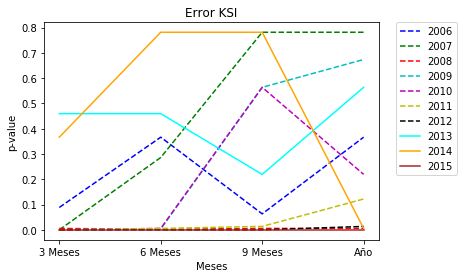

In [28]:
plt.title("Error KSI")
pylab.xlabel("Meses")
pylab.ylabel("p-value")
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2006, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--b', label='2006')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2007, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--g', label='2007')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2008, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--r', label='2008')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2009, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--c', label='2009')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2010, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--m', label='2010')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2011, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--y', label='2011')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2012, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'--k', label='2012')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2013, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'cyan', label='2013')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2014, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'orange', label='2014')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2015, ['KSI 3 Meses','KSI 6 Meses','KSI 9 Meses','KSI Año']],'brown', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.savefig(os.path.join(output_dir,'medellin_ksi.png'), dpi=600)

Para el caso del KSI, cuando se evalua el p-value se desea que este sea lo mas cercano a 1, esto quiere decir que las series de datos comparadas se asemejan entre si. Para esta aplicacion se desea evaluar en que ocasiones este p-value muestra semejanza entre las series para determinado período de meses ajustados, en la gráfica se observa que para los años 2011, 2012 y 2012 las series ajustadas no se asemejan a la de IDEAM, por tanto no resultan significativas a la hora de tomar decisiones con esas medidas. Por otra parte, los años 2007, 2009 y 2013 incrementan el p-value al acercarse al año lo cual permite analizar el calculo de la ENFICC para estos datos ajustados, mientras que el año 2014 permiten hacerlo cuando el ajuste de la serie se realiza a 9 meses. 

En términos generales no es recomendable tomar decisiones cuando la serie ajustada evualada tiene un rango de tiempo menos a 6 meses, esto comprueba lo mencionado en el protocolo.

## MBE

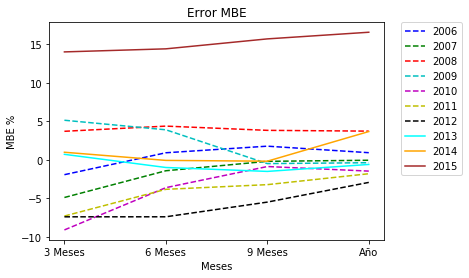

In [29]:
plt.title("Error MBE")
pylab.xlabel("Meses")
pylab.ylabel("MBE %")
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2006, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--b', label='2006')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2007, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--g', label='2007')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2008, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--r', label='2008')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2009, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--c', label='2009')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2010, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--m', label='2010')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2011, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--y', label='2011')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2012, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'--k', label='2012')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2013, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'cyan', label='2013')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2014, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'orange', label='2014')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2015, ['MBE 3 Meses %','MBE 6 Meses %','MBE 9 Meses %','MBE Año %']],'brown', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.savefig(os.path.join(output_dir,'medellin_mbe.png'), dpi=600)

Para este tipo de errores se desea que las series se encuentran en un rango de +/- 5% de error, en este caso los años 2010, 2011 y 2012 no son correctas para analizar en periodos menores a 6 meses. La serie del año 2015 presenta un error muy grande como para tomar decisiones con este ajuste. 

Se determina que mientras la serie ajustada se acerque al período de un año el error disminuye.

## RMSEn 

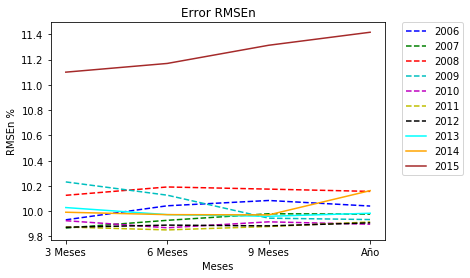

In [30]:
plt.title("Error RMSEn")
pylab.xlabel("Meses")
pylab.ylabel("RMSEn %")
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2006, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--b', label='2006')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2007, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--g', label='2007')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2008, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--r', label='2008')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2009, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--c', label='2009')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2010, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--m', label='2010')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2011, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--y', label='2011')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2012, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'--k', label='2012')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2013, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'cyan', label='2013')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2014, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'orange', label='2014')
pylab.plot(['3 Meses','6 Meses','9 Meses', 'Año'],errores.loc[2015, ['RMSEn 3 Meses %','RMSEn 6 Meses %','RMSEn 9 Meses %','RMSEn Año %']],'brown', label='2015')
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
pylab.savefig(os.path.join(output_dir,'medellin_rmsen.png'), dpi=600)

En este caso en el error con el ajuste de la serie NREL se observa que todos los años a excepción del año 2015, se mantiene en un rango general de errores (Entre 9.8% y 10.4%) y no depende, en este caso, del período de tiempo en el que se estudie la serie.

# Conclusiones

Los errores MBE como RMSEn disminuyen cuando el período de tiempo ajustado es mayor a 6 meses, a su vez el p-value del calculo KSI aumenta con este periodo de tiempo. Sin embargo, esto no ocurre para todos los años, según el año de ajuste este puede variar en términos de cálculo del error, el año 2015 es muestra de esto, de este modo es mejor analizar diferentes años para observar cual reduce el error y ademas su ajuste de tiempo tiene una distribucion similar a la de IDEAM. 